# BAYESIAN OPTIMIZATION - CODING

![BO](BO.jpg)

## PSEUDO CODE

This script aims to realize Bayesian Optimization using sequential Gaussian Process (GP) as surrogate model. The algorithm is based on the following steps:

1. **Initialization**: Select a set of initial points to evaluate the objective function.
2. **Model Fitting**: Fit a GP model to the data.
3. **Acquisition Function**: Define an acquisition function to determine the next point to evaluate.
4. **Optimization**: Find the next point that maximizes the acquisition function.
5. **Update**: Evaluate the objective function at the selected point and add it to the dataset.
6. **Repeat**: Repeat steps 2-5 until the stopping criterion is met.

![BO](BAYESIAN-OPTIMIZATION.png)

## INGREDIENTS

0: THE SEARCH SPACE $X$ - ${[lb_1,ub_1],...,[lb_m,ub_m]}$

1: THE OBJECTIVE FUNCTION $f(x)$ - the black box

2: THE DATASET $D$ - $\{(x_1, y_1), (x_2, y_2), ..., (x_t, y_t)\}$

3: THE SURROGATE MODEL $M(x)$ - Gaussian Process

4: THE ACQUISITION FUNCTION $S(x)$ - Expected Improvement (EI)

5: THE OPTIMIZATION ALGORITHM - L-BFGS-B

6: THE STOPPING CRITERION - Maximum number of iterations / Tolerance

## REALIZATION

### Helpers

In [1]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CONFIGURABLE PARAMETERS

## Hyperparameters
noise_lvl = 0.1
k_alpha = 1
k_lambda = 1

## Process Control
num_init_points = 10
num_iter = 20
tolerance = 1e-3
gap = np.inf

## Acquisition Function - UCB
beta = 2

In [3]:
## Search Space
### parameter 1 - a
lb_a = -6
ub_a = 4
c_a = (ub_a + lb_a) / 2
print(c_a)

### parameter 2 - b
lb_b = -4
ub_b = 6
c_b = (ub_b + lb_b) / 2
print(c_b)

-1.0
1.0


In [4]:
# THE OBJECTIVE FUNCTION - this is actually the black box, here I use a simple example to represent the black box
def objective_function(a, b):
    ret = -1*(a-c_a)**2 - 1*(b-c_b)**2 + 25
    # noise term
    noise = np.random.normal(0, noise_lvl)
    ret += noise
    return ret

In [5]:
# THE SURROGATE MODEL - Gaussian Process - Kernel Function
## Matern 2.5 as the kernel function
def kernel(p1, p2, matern_alpha = 1, matern_lambda = 1):
    # define the distance between two points p1 and p2
    d= np.linalg.norm(p1 - p2)
    k = matern_alpha * (1 + np.sqrt(5) * d / matern_lambda + 5 * d**2 / (3 * matern_lambda**2)) * np.exp(-np.sqrt(5) * d / matern_lambda)
    return k

## Mean and Variance of the Gaussian Process
def mean_var(x, D, K_alpha, k_lambda):
    # assume x is a variable of 1x1
    # calculate the mean and variance of the Gaussian Process
    x_dim = x.shape[1] # assume each colum is a dimension of x
    num_D = D.shape[0] # number of data points in D
    
    Ktt = np.zeros((num_D, num_D))
    for i in range(num_D):
        for j in range(num_D):
            Ktt[i, j] = kernel(D[i,:-1], D[j,:-1], K_alpha, k_lambda)
    Kttn = Ktt + np.eye(num_D) * noise_lvl
    IKttn = np.linalg.inv(Kttn)
    
    Kpt = np.zeros((1, num_D))
    for i in range(num_D):
        Kpt[0, i] = kernel(x, D[i,:-1], K_alpha, k_lambda)
    Ktp = Kpt.T
    Kpp = kernel(x, x, K_alpha, k_lambda)
    
    y = D[:,-1].reshape(-1,1)
    
    mean = Kpt @ IKttn @ y
    var = Kpp - Kpt @ IKttn @ Ktp
        
    return mean, var

In [6]:
# THE ACQUISITION FUNCTION - UPPER CONFIDENCE BOUND
def S(x, D):
    mean, var = mean_var(x, D, k_alpha, k_lambda)
    s = mean + beta * np.sqrt(var)
    return s

In [7]:
# THE OPTIMIZATION FUNCTION FOR THE ACQUISITION FUNCTION
def optimize_acquisition(D):
    # randomly search for the point with the highest acquisition function value
    num_search = 100
    max_s = -np.inf
    max_x = None
    cur_x = np.zeros((1,2))
    for i in range(num_search):
        cur_x[0,0] = np.random.uniform(lb_a, ub_a)
        cur_x[0,1] = np.random.uniform(lb_b, ub_b)
        cur_s = S(cur_x, D)
        if cur_s > max_s:
            max_s = cur_s
            max_x = cur_x.copy()
    return max_x

### The Optimization Process

In [8]:
# PHASE 1 - INITIAL DATASET
D = np.zeros((num_init_points, 3)) # first column is a, second column is b, third column is the objective function value
for i in range(num_init_points):
    a = np.random.uniform(lb_a, ub_a)
    b = np.random.uniform(lb_b, ub_b)
    D[i, 0] = a
    D[i, 1] = b
    D[i, 2] = objective_function(a, b)

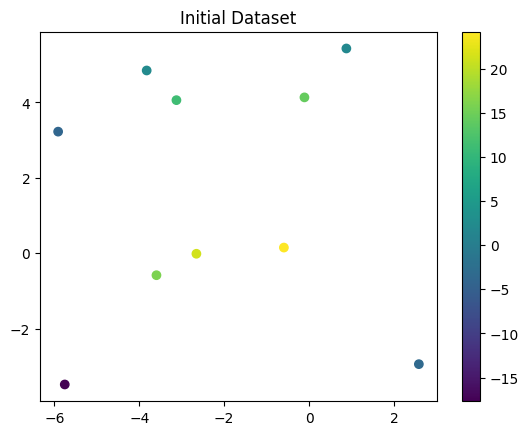

In [9]:
# plot the initial dataset
plt.figure()
plt.scatter(D[:,0], D[:,1], c=D[:,2], cmap='viridis')
plt.colorbar()
plt.title('Initial Dataset')
plt.show()

In [10]:
# PHASE 2 - OPTIMIZATION ITERATIONS
for i in range(num_iter):
    
    # (1) use the surrogate model to approach the posterior distribution of the objective function, modeled by Gaussian Process which can be characterized by the mean function and the covariance function
    
    ## mean, var = mean_var(x, D, 1, 1)
    
    # (2) determine the next point to evaluate using the acquisition function S(D)
    x_eval = optimize_acquisition(D)
    
    # (3) evaluate the objective function at the next point
    f_eval = objective_function(x_eval[0,0], x_eval[0,1])
    
    # (4) update the dataset D
    newpoint = np.zeros((1,3))
    newpoint[0,0] = x_eval[0,0]
    newpoint[0,1] = x_eval[0,1]
    newpoint[0,2] = f_eval
    D = np.vstack((D, newpoint))
    
    # (5) check the stopping criterion
    gap = np.abs(D[-1, -1] - D[-2, -1])
    if gap < tolerance:
        break
    


In [11]:
# number of points in D
print(D.shape[0])

30


In [12]:
# print the final value
print(D[-1, -1])

# print the max value
print(np.max(D[:, -1]))

# print the argmax
print(D[np.argmax(D[:, -1]), :-1])

24.293596368636074
25.010182155841417
[-0.91806544  0.62069064]


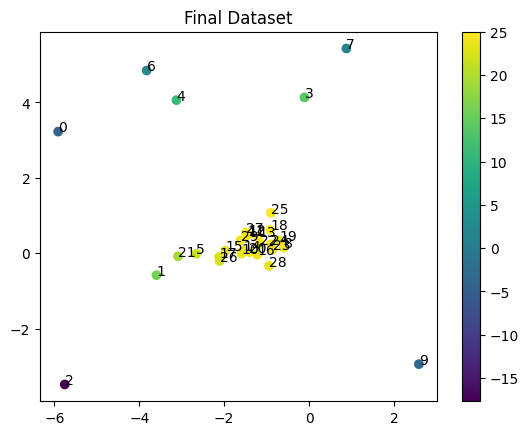

In [13]:
# plot the final dataset and mark the order of the points, mark the max point
plt.figure()
plt.scatter(D[:,0], D[:,1], c=D[:,2], cmap='viridis')
for i in range(D.shape[0]):
    plt.text(D[i,0], D[i,1], str(i))
plt.colorbar()
plt.title('Final Dataset')
plt.show()

